# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 02.02.2024

Мягкий дедлайн: 23:59MSK 19.02.2024

Жесткий дедлайн: 23:59MSK 25.02.2024

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [11]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score

class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.

        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.

        use_PCA, bool: whether to include PCA preprocessing.

        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.

        Feel free to edit this template for your preferences.
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.weights = []
        self.biases = []
        self.scaler = None
        self.model = None
        self.pca = None

    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """

        self.scaler = Normalizer()
        new_X = self.scaler.fit_transform(X)

        #1
        if self.use_PCA:
          self.pca = PCA(n_components=self.new_dim)
          new_X = self.pca.fit_transform(new_X)

        print("Done PCA")

        #2
        indices = np.random.choice(np.arange(new_X.shape[0]), size=(2, min(1000000, X.shape[0])))
        first = indices[0]
        second = indices[1]
        indices = indices[:, first != second]
        sigma_array = np.sum((new_X[first] - new_X[second])**2, axis=1)
        sigma = np.median(sigma_array)
        print('Done sigma', sigma)
        #3
        self.weights = np.random.normal(loc=0, scale=1/sigma, size=(new_X.shape[1], self.n_features))
        self.biases = np.random.uniform(low=-np.pi, high=np.pi, size=self.n_features)

        #4
        new_features = np.cos(new_X @ self.weights + np.repeat([self.biases], new_X.shape[0], axis=0))

        #5
        if self.classifier == 'logreg':
          self.model = LogisticRegression()
        else:
          self.model = LinearSVC()
        self.model.fit(new_features, y)
        print('Done fitting')

        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        new_X = self.scaler.transform(X)
        if self.use_PCA:
          new_X = self.pca.transform(new_X)

        new_features = np.cos(new_X @ self.weights + self.biases)

        if self.classifier == 'logreg':
          probas = self.model.predict_proba(new_features)[:,1]
        else:
          probas = self.model.decision_function(new_features)

        return probas

    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        new_X = self.scaler.transform(X)
        if self.use_PCA:
          new_X = self.pca.transform(new_X)

        new_features = np.cos(new_X @ self.weights + np.repeat([self.biases], new_X.shape[0], axis=0))

        return self.model.predict(new_features)


In [3]:
model = RFFPipeline()

model.fit(x_train, y_train)
print("Accuracy = ", accuracy_score(y_test, model.predict(x_test)))

Done PCA
Done sigma 0.6360057709314345


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Done fitting
Accuracy =  0.8657


__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [5]:
indices = np.random.choice(np.arange(x_train.shape[0]), size=int(x_train.shape[0] * 0.5), replace=False)

linear_model = LinearSVC()
linear_model.fit(x_train[indices], y_train[indices])
y_pred_lin = linear_model.predict(x_test)

kernel_model = RFFPipeline(classifier='SVC')
kernel_model.fit(x_train[indices], y_train[indices])
y_pred_kernel = kernel_model.predict(x_test)
print("Linear model accuracy = ", accuracy_score(y_test, y_pred_lin))
print("Kernel model accuracy = ", accuracy_score(y_test, y_pred_kernel))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Done PCA
Done sigma 0.6362324832572317


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Done fitting
Linear model accuracy =  0.7933
Kernel model accuracy =  0.8679


In [6]:
import xgboost as xgb

pca = PCA(n_components=50)
new_x_train = pca.fit_transform(x_train)
new_x_test = pca.fit_transform(x_test)

lrs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0]

val_indices = np.random.choice(np.arange(new_x_test.shape[0]), size=(2, int(new_x_test.shape[0] * 0.5)), replace=False)
new_x_val = new_x_test[val_indices[0]]
new_x_test = new_x_test[val_indices[1]]
new_y_val = y_test[val_indices[0]]
new_y_test = y_test[val_indices[1]]

for lr in lrs:
  boost_model = xgb.XGBClassifier(learning_rate=lr)
  boost_model.fit(new_x_train, y_train)
  print(f'Learning rate {lr} boosting accuracy {accuracy_score(new_y_val, boost_model.predict(new_x_val))}')

Learning rate 0.0001 boosting accuracy 0.5422
Learning rate 0.001 boosting accuracy 0.539
Learning rate 0.01 boosting accuracy 0.5522
Learning rate 0.1 boosting accuracy 0.5702
Learning rate 1.0 boosting accuracy 0.544


In [7]:
best_lr = 0.1
estimators = [50, 100, 150, 200, 300, 400, 500]

for n_estimators in estimators:
  boost_model = xgb.XGBClassifier(learning_rate=best_lr, n_estimators=n_estimators)
  boost_model.fit(new_x_train, y_train)
  print(f'Estimators number {n_estimators} boosting accuracy {accuracy_score(new_y_val, boost_model.predict(new_x_val))}')

Estimators number 50 boosting accuracy 0.556
Estimators number 100 boosting accuracy 0.5702
Estimators number 150 boosting accuracy 0.5706
Estimators number 200 boosting accuracy 0.567
Estimators number 300 boosting accuracy 0.5648
Estimators number 400 boosting accuracy 0.5636
Estimators number 500 boosting accuracy 0.5632


In [8]:
best_n_estimators = 150
boost_model = xgb.XGBClassifier(learning_rate=best_lr, n_estimators=best_n_estimators)
boost_model.fit(new_x_train, y_train)
print(f'Best boosting accuracy {accuracy_score(new_y_test, boost_model.predict(new_x_test))}')

Best boosting accuracy 0.5604


Как мы видим из тестов известные нам методы справляются с поставленной задачей хуже, чем ядровой подход. Что касается времени обучения - я не заметил большой разницы между обучением линейного и ядрового SVC (ядровой чуть дольше, но совсем не критично). Время обучения бустинга зависит от количества деревьев. Оптимальный бустинг обучился быстрее, чем ядровой SVC, но едва ли это сравнение имеет значение, так как разница в качестве слишком большая

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA?
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

In [9]:
noPCA_model = RFFPipeline(use_PCA=False)
noPCA_model.fit(x_train, y_train)
y_pred_kernel = noPCA_model.predict(x_test)
print("Kernel model with PCA accuracy = ", 0.8657)
print("Kernel model without PCA accuracy = ", accuracy_score(y_test, y_pred_kernel))

Done PCA
Done sigma 0.7994506823707277


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Done fitting
Kernel model with PCA accuracy =  0.8657
Kernel model without PCA accuracy =  0.8672


Проведённый эксперимент показывает, что понижение размерности качество модели не увеличивает, но помогает в скорости

In [ ]:
features = [250, 500, 1000, 1500, 2000, 3000, 5000, 7500]
val_indices = np.random.choice(np.arange(x_test.shape[0]), size=(2, int(x_test.shape[0] * 0.5)), replace=False)

new_x_val = x_test[val_indices[0]]
new_x_test = x_test[val_indices[1]]
new_y_val = y_test[val_indices[0]]
new_y_test = y_test[val_indices[1]]

accuracies = []

for n_features in features:
  model = RFFPipeline(n_features=n_features)
  model.fit(x_train, y_train)
  accuracies.append(accuracy_score(new_y_val, model.predict(new_x_val)))
  print(f'Features number {n_features} kernel accuracy {accuracy_score(new_y_val, model.predict(new_x_val))}')

[Text(0.5, 1.0, 'Dependence of accuracy on number of features'),
 Text(0.5, 0, 'n_features'),
 Text(0, 0.5, 'accuracy')]

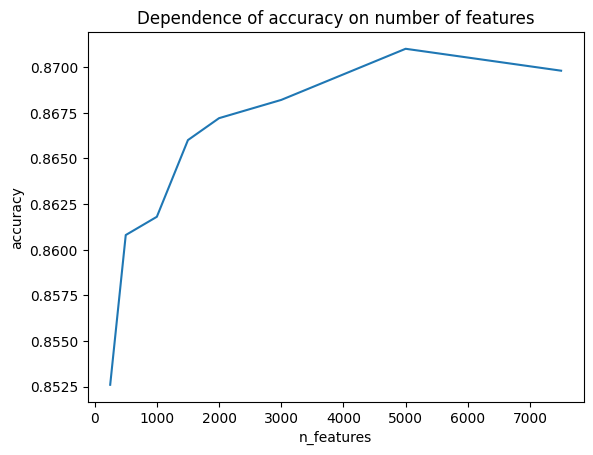

In [6]:
import seaborn as sns

sns.lineplot(x=features, y=accuracies).set(title='Dependence of accuracy on number of features', xlabel='n_features', ylabel='accuracy')

Из графика видно, что точность изменяется незначительно, можно сказать, что вышли на плато

In [12]:
svc_kernel_model = RFFPipeline(classifier='SVC')
svc_kernel_model.fit(x_train, y_train)
y_pred_svc = svc_kernel_model.predict(x_test)

log_kernel_model = RFFPipeline()
log_kernel_model.fit(x_train, y_train)
y_pred_log = log_kernel_model.predict(x_test)

print("SVC kernel model accuracy = ", accuracy_score(y_test, y_pred_svc))
print("Logistic kernel model accuracy = ", accuracy_score(y_test, y_pred_log))

Done PCA
Done sigma 0.6388333550721654


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Done fitting
Done PCA
Done sigma 0.6367766662303486


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Done fitting
SVC kernel model accuracy =  0.8677
Logistic kernel model accuracy =  0.8669


В контексте данной задачи и данных, разница в качестве между двумя подходами небольшая, но SVM обучается дольше, поэтому разница с точки зрения производительности есть

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

__Задание 5. (Максимум 1 балл)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

__Задание 6. (Максимум 1 балл)__

Реализуйте класс ядровой Ridge регрессии (Лекция 13, $\S 1.2$), для оптимизации используте градиентный спуск, а не аналитическую формулу. Также подумайте о том, как в формулах правильно учесть свободный коэффициент. Затем адаптируйте вашу реализацию RFF под задачу регрессии. Сравните вашу ядровую регрессию и RFF на синтетических данных.

Функция потерь:
$$
Q(w) = \frac{1}{2} ||\Phi \Phi^T w - y||^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w \rightarrow \min_w,
$$
где $\Phi \Phi^T = K$, $K = (k(x_i, x_j))_{i, j = 1}^{\ell}$.

Предсказание:
$
y(x) = k(x)^T w,
$
где $k(x)$ — вектор функций ядра от пар объектов $(x, x_i)_{i=1}^{\ell}$.

Вы можете изменять представленный ниже шаблон по своему усмотрению.

In [ ]:
import numpy as np
from sklearn.base import RegressorMixin
from sklearn.gaussian_process.kernels import RBF

class KernelRidgeRegression(RegressorMixin):
    """
    Kernel Ridge regression class
    """

    def __init__(self,
        lr=0.01,
        regularization=1.,
        tolerance=1e-2,
        max_iter=1000,
        batch_size=64,
        kernel_scale=1.
    ):
        """
        :param lr: learning rate
        :param regularization: regularization coefficient
        :param tolerance: stopping criterion for square of euclidean norm of weight difference
        :param max_iter: stopping criterion for iterations
        :param batch_size: size of the batches used in gradient descent steps
        :parame kernel_scale: length scale in RBF kernel formula
        """

        self.lr: float = lr
        self.regularization: float = regularization
        self.w: np.ndarray | None = None

        self.tolerance: float = tolerance
        self.max_iter: int = max_iter
        self.batch_size: int = batch_size
        self.loss_history: list[float] = []
        self.kernel = RBF(kernel_scale)

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating loss for x and y dataset
        :param x: features array
        :param y: targets array
        """
        raise NotImplementedError

    def calc_grad(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating gradient for x and y dataset
        :param x: features array
        :param y: targets array
        """
        raise NotImplementedError

    def fit(self, x: np.ndarray, y: np.ndarray) -> "KernelRidgeRegression":
        """
        Fitting weights for x and y dataset
        :param x: features array
        :param y: targets array
        :return: self
        """
        raise NotImplementedError

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Predicting targets for x dataset
        :param x: features array
        :return: prediction: np.ndarray
        """
        raise NotImplementedError